In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import os
from datetime import datetime
from tqdm import tqdm
import cv2

print('tf.__version__', tf.__version__)
print('cv2.__version__', cv2.__version__)

tf.__version__ 2.17.1
cv2.__version__ 4.10.0


In [2]:
!python --version

Python 3.10.12


In [3]:
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import os

In [4]:
# Image size for resizing
IMAGE_SIZE = (256, 256)

EPOCHS = 40

# Define directories for logging and saving
LOG_DIR = '/kaggle/working/logs'
CHECKPOINT_DIR = '/kaggle/working/checkpoints'

# Define dataset directories for subclassification
subcategory_dirs = {
    'asphalt': {
        'bad': ['/kaggle/input/road-traversing-knowledge-rtk-dataset/RTK_Dataset/asphalt/asphaltBad'],
        'good': ['/kaggle/input/road-traversing-knowledge-rtk-dataset/RTK_Dataset/asphalt/asphaltGood'],
        'regular': ['/kaggle/input/road-traversing-knowledge-rtk-dataset/RTK_Dataset/asphalt/asphaltRegular']
    },
    'paved': {
        'bad': ['/kaggle/input/road-traversing-knowledge-rtk-dataset/RTK_Dataset/paved/pavedBad'],
        'regular': ['/kaggle/input/road-traversing-knowledge-rtk-dataset/RTK_Dataset/paved/pavedRegular']
    },
    'unpaved': {
        'bad': ['/kaggle/input/road-traversing-knowledge-rtk-dataset/RTK_Dataset/upaved/unpavedBad'],
        'regular': ['/kaggle/input/road-traversing-knowledge-rtk-dataset/RTK_Dataset/upaved/unpavedRegular']
    }
}

In [5]:
# Custom DenseNet121 model
def build_densenet121_model():
    base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
    base_model.trainable = False  # Freeze base model layers
    
    model = tf.keras.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(3, activation='softmax')  # 3 classes: asphalt, paved, unpaved or bad, good, regular
    ])
    
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model



# Custom DenseNet121 model For Two Class
def build_densenet121_model_For_two():
    base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
    base_model.trainable = False  # Freeze base model layers
    
    model = tf.keras.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(2, activation='sigmoid')  # 3 classes: Bad, Regular
    ])
    
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [6]:
def load_images_from_folder(folder, image_size=(256, 256)):
    # Mapping from subfolder name to integer labels for 'bad', 'regular', and 'good' road types
    label_map = {
        'Bad': 0,       # "bad" roads
        'Regular': 1,   # "regular" roads
        'Good': 2       # "good" roads
    }
    
    images = []
    labels = []
    
    for filename in os.listdir(folder):
        if filename.lower().endswith(('png', 'jpg', 'jpeg')):
            img = load_img(os.path.join(folder, filename), target_size=image_size)
            img_array = img_to_array(img)
            images.append(img_array)
            for _ in label_map.keys():
                if _ in folder:
                    class_label = label_map[_]
            labels.append(class_label)  # You can change this if the label should be something else, like 0 or 1
    return np.array(images), np.array(labels)


def load_road_type_data(subcategory_dirs, category, image_size=IMAGE_SIZE, batch_size=32):
    # Initialize lists for data
    train_data, val_data = [], []
    for subcategory, dirs in subcategory_dirs[category].items():
        # Load data and labels from each subcategory
        for folder in dirs:
            images, labels = load_images_from_folder(folder, image_size)  # Implement load_images_from_folder to return images and their labels
            
            # Split the data into training and validation (e.g., 80%-20%)
            train_images, val_images, train_labels, val_labels = train_test_split(images, labels, test_size=0.2)
            
            train_data.append((train_images, train_labels))
            val_data.append((val_images, val_labels))
    
    if not train_data or not val_data:
        raise ValueError(f"No data found for category: {category}")
    
    # Flatten the list of data into the training and validation sets
    X_train, y_train = zip(*train_data)
    X_val, y_val = zip(*val_data)
    
    # Concatenate the arrays from all subcategories
    X_train = np.concatenate(X_train, axis=0)
    y_train = np.concatenate(y_train, axis=0)
    X_val = np.concatenate(X_val, axis=0)
    y_val = np.concatenate(y_val, axis=0)
    
    return X_train, y_train, X_val, y_val


    # Load data from the subcategories: bad, regular, good
    train_bad, val_bad = create_generator('bad')
    train_regular, val_regular = create_generator('regular')
    train_good, val_good = create_generator('good')

    # Combine data from the three subcategories into the final dataset
    X_train = np.concatenate([train_bad[0], train_regular[0], train_good[0]], axis=0)
    y_train = np.concatenate([train_bad[1], train_regular[1], train_good[1]], axis=0)
    X_val = np.concatenate([val_bad[0], val_regular[0], val_good[0]], axis=0)
    y_val = np.concatenate([val_bad[1], val_regular[1], val_good[1]], axis=0)
    
    return X_train, y_train, X_val, y_val


In [7]:
def check_image_folders(subcategory_dirs):
    for category, subcategories in subcategory_dirs.items():
        for subcategory, directories in subcategories.items():
            total_files = 0
            for directory in directories:
                files = os.listdir(directory)
                total_files += len([f for f in files if f.lower().endswith(('png', 'jpg', 'jpeg'))])
            print(f"{category} - {subcategory}: {total_files} image(s)")
check_image_folders(subcategory_dirs)

asphalt - bad: 464 image(s)
asphalt - good: 1978 image(s)
asphalt - regular: 839 image(s)
paved - bad: 124 image(s)
paved - regular: 324 image(s)
unpaved - bad: 593 image(s)
unpaved - regular: 796 image(s)


In [8]:
    # Initialize the data for asphalt, paved, and unpaved
    X_train_asphalt, y_train_asphalt, X_val_asphalt, y_val_asphalt = load_road_type_data(subcategory_dirs, 'asphalt')
    X_train_paved, y_train_paved, X_val_paved, y_val_paved = load_road_type_data(subcategory_dirs, 'paved')
    X_train_unpaved, y_train_unpaved, X_val_unpaved, y_val_unpaved = load_road_type_data(subcategory_dirs, 'unpaved')

In [9]:
set(y_train_asphalt), set(y_train_paved), set(y_train_unpaved)

({0, 1, 2}, {0, 1}, {0, 1})

In [10]:
len(X_train_asphalt)+len(X_val_asphalt)

3281

In [11]:
import os
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
import numpy as np

def train_and_evaluate_models(subcategory_dirs, image_size=IMAGE_SIZE, epochs=EPOCHS):

    # Create directories if they don't exist
    os.makedirs(LOG_DIR, exist_ok=True)
    os.makedirs(CHECKPOINT_DIR, exist_ok=True)
    
    # Initialize models for asphalt, paved, and unpaved
    models = {}

    # Define a function to handle training, evaluation, and reporting for each model
    def train_and_evaluate_category(model, X_train, y_train, X_val, y_val, category_name):
        # Set callbacks for TensorBoard and Model Checkpoints
        tensorboard_cb = TensorBoard(log_dir=LOG_DIR, histogram_freq=1)
        checkpoint_cb = ModelCheckpoint(
            filepath=os.path.join(CHECKPOINT_DIR, f'model_{category_name}.keras'),
            save_weights_only=False,
            save_best_only=True,
            monitor='val_loss',
            mode='min',
            verbose=1
        )

        # Train the model
        history = model.fit(
            X_train, y_train,
            epochs=epochs,
            validation_data=(X_val, y_val),
            callbacks=[tensorboard_cb, checkpoint_cb]
        )
        
        # Evaluate the model
        test_loss, test_acc = model.evaluate(X_val, y_val, verbose=2)
        print(f"Test Loss for {category_name}: {test_loss}, Test Accuracy for {category_name}: {test_acc}")

        # Print Classification Report using sklearn
        y_pred = model.predict(X_val)
        y_pred_classes = np.argmax(y_pred, axis=-1)
        print(f"Classification Report for {category_name}:\n")
        print(classification_report(y_val, y_pred_classes))

        # Plot training & validation accuracy/loss
        plot_metrics(history, category_name)

        return history

    def plot_metrics(history, category_name):
        # Plot training & validation accuracy
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.plot(history.history['accuracy'], label='Train Accuracy')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.title(f'Accuracy: {category_name}')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()

        # Plot training & validation loss
        plt.subplot(1, 2, 2)
        plt.plot(history.history['loss'], label='Train Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title(f'Loss: {category_name}')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

        # Save and show the plot
        plt.tight_layout()
        plt.savefig(f"{category_name}_metrics.png")
        plt.show()

    # Model Training and Evaluation for Asphalt, Paved, and Unpaved
    print("Training and evaluating Asphalt model...")
    model_asphalt = build_densenet121_model()  # Multi-class model for asphalt
    history_asphalt = train_and_evaluate_category(model_asphalt, X_train_asphalt, y_train_asphalt, X_val_asphalt, y_val_asphalt, "Asphalt")
    
    print("Training and evaluating Paved model...")
    model_paved = build_densenet121_model()  # Multi-class model for paved
    history_paved = train_and_evaluate_category(model_paved, X_train_paved, y_train_paved, X_val_paved, y_val_paved, "Paved")
    
    print("Training and evaluating Unpaved model...")
    model_unpaved = build_densenet121_model()  # Multi-class model for unpaved
    history_unpaved = train_and_evaluate_category(model_unpaved, X_train_unpaved, y_train_unpaved, X_val_unpaved, y_val_unpaved, "Unpaved")
    
    return model_asphalt, model_paved, model_unpaved


Training and evaluating Asphalt model...
29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/40
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.6614 - loss: 2.8132
Epoch 1: val_loss improved from inf to 0.37868, saving model to /kaggle/working/checkpoints/model_Asphalt.keras
82/82 ━━━━━━━━━━━━━━━━━━━━ 56s 386ms/step - accuracy: 0.6622 - loss: 2.7985 - val_accuracy: 0.8524 - val_loss: 0.3787
Epoch 2/40
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.8459 - loss: 0.3965
Epoch 2: val_loss improved from 0.37868 to 0.35712, saving model to /kaggle/working/checkpoints/model_Asphalt.keras
82/82 ━━━━━━━━━━━━━━━━━━━━ 14s 167ms/step - accuracy: 0.8458 - loss: 0.3966 - val_accuracy: 0.8645 - val_loss: 0.3571
Epoch 3/40
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.8507 - loss: 0.3886
Epoch 3: val_loss improved from 0.35712 to 0.29346, saving model to /kaggle/working/checkpoints/model_Asphalt.keras
82/82 ━━━━━━━━━━━━━━━━━━━━ 14s 167ms/step - accuracy: 0.8508 - loss: 0.38

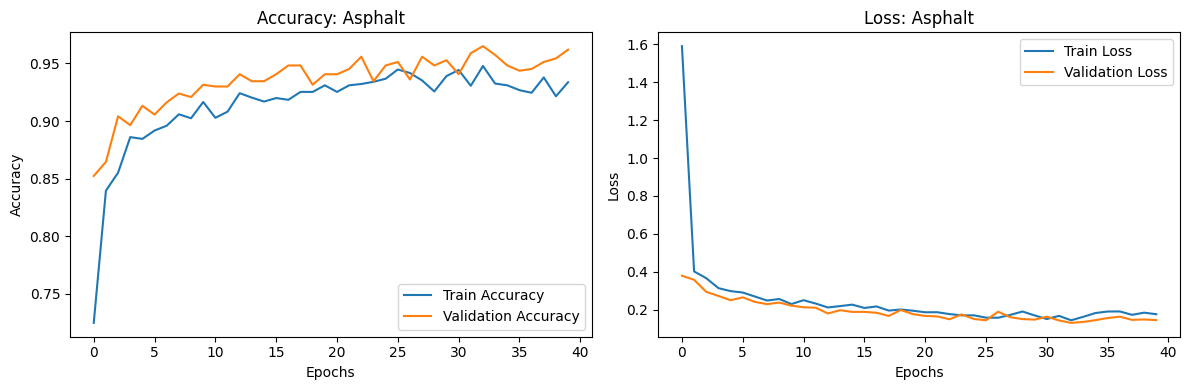

Training and evaluating Paved model...
Epoch 1/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 948ms/step - accuracy: 0.6092 - loss: 4.6772
Epoch 1: val_loss improved from inf to 1.51272, saving model to /kaggle/working/checkpoints/model_Paved.keras
12/12 ━━━━━━━━━━━━━━━━━━━━ 51s 3s/step - accuracy: 0.6109 - loss: 4.6379 - val_accuracy: 0.7222 - val_loss: 1.5127
Epoch 2/40
11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.6407 - loss: 1.9643
Epoch 2: val_loss improved from 1.51272 to 0.62015, saving model to /kaggle/working/checkpoints/model_Paved.keras
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 556ms/step - accuracy: 0.6444 - loss: 1.9325 - val_accuracy: 0.8000 - val_loss: 0.6201
Epoch 3/40
11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.7390 - loss: 1.0464
Epoch 3: val_loss improved from 0.62015 to 0.35535, saving model to /kaggle/working/checkpoints/model_Paved.keras
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 551ms/step - accuracy: 0.7414 - loss: 1.0352 - val_accuracy: 0.8444 - val_loss: 0.3554
Epoch 4/40
11/12 ━

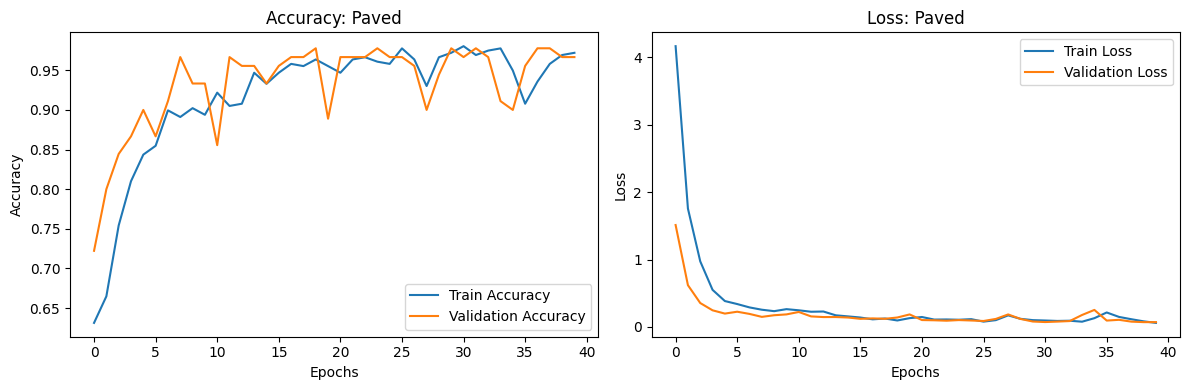

Training and evaluating Unpaved model...
Epoch 1/40
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step - accuracy: 0.6655 - loss: 1.9002
Epoch 1: val_loss improved from inf to 0.27548, saving model to /kaggle/working/checkpoints/model_Unpaved.keras
35/35 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - accuracy: 0.6687 - loss: 1.8814 - val_accuracy: 0.9211 - val_loss: 0.2755
Epoch 2/40
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.9032 - loss: 0.3699
Epoch 2: val_loss improved from 0.27548 to 0.14609, saving model to /kaggle/working/checkpoints/model_Unpaved.keras
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 255ms/step - accuracy: 0.9030 - loss: 0.3704 - val_accuracy: 0.9570 - val_loss: 0.1461
Epoch 3/40
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.9223 - loss: 0.2731
Epoch 3: val_loss improved from 0.14609 to 0.07928, saving model to /kaggle/working/checkpoints/model_Unpaved.keras
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 259ms/step - accuracy: 0.9228 - loss: 0.2710 - val_accuracy: 0.9857 - val_loss: 0.0793
Epoch 4/40

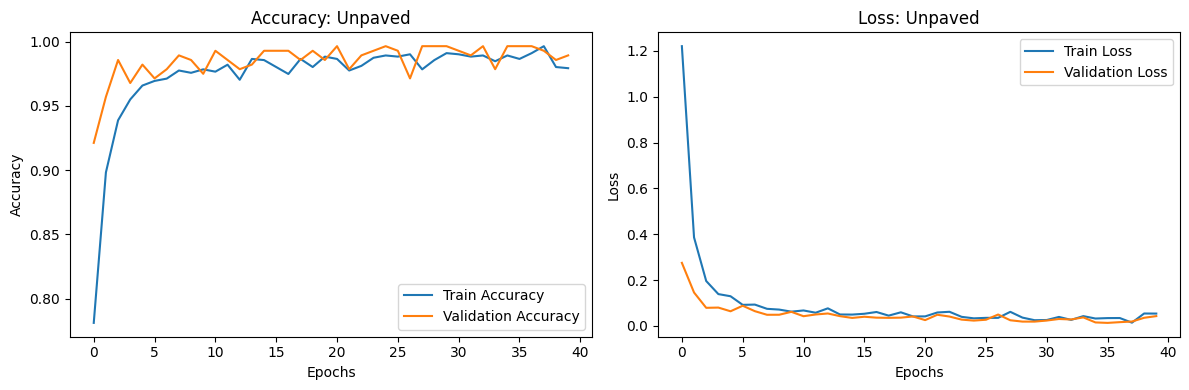

(<Sequential name=sequential, built=True>,
 <Sequential name=sequential_1, built=True>,
 <Sequential name=sequential_2, built=True>)

In [12]:
train_and_evaluate_models(subcategory_dirs, image_size=IMAGE_SIZE, epochs=EPOCHS)

In [13]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import os

# Define model paths (pointing to full models)
MODEL_PATHS = {
    "asphalt": "/kaggle/working/checkpoints/model_Asphalt.keras",
    "paved": "/kaggle/working/checkpoints/model_Paved.keras",
    "unpaved": "/kaggle/working/checkpoints/model_Unpaved.keras"
}

# Define image size
IMAGE_SIZE = (256, 256)

# Load models
models = {}
for road_type, model_path in MODEL_PATHS.items():
    if os.path.exists(model_path):  # Ensure the model file exists
        model = tf.keras.models.load_model(model_path)
        models[road_type] = model
        print(f"Loaded model for {road_type}")
    else:
        print(f"Warning: Model file {model_path} not found!")

# Function to preprocess image
def preprocess_image(image_path):
    img = load_img(image_path, target_size=IMAGE_SIZE)
    img_array = img_to_array(img) / 255.0  # Normalize
    img_array = np.expand_dims(img_array, axis=0)  # Expand dimensions for batch
    return img_array

# Function to predict road condition
def predict_road_condition(image_path):
    img_array = preprocess_image(image_path)
    predictions = {}
    for road_type, model in models.items():
        pred = model.predict(img_array)
        predicted_class = np.argmax(pred, axis=-1)[0]
        predictions[road_type] = predicted_class
    return predictions

# Example usage
image_path = "/kaggle/input/road-traversing-knowledge-rtk-dataset/RTK_Dataset/paved/pavedRegular/000000001.png"  # Change this to your test image path
predictions = predict_road_condition(image_path)
print("Predictions:", predictions)


Loaded model for asphalt
Loaded model for paved
Loaded model for unpaved
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
Predictions: {'asphalt': 2, 'paved': 1, 'unpaved': 1}
